## Import Batman

In [1]:
from batman import TransitModel, TransitParams
from batman.openmp import detect
import timeit
import numpy as np
import matplotlib.pyplot as plt

from batman import _nonlinear_ld
from batman import _quadratic_ld
from batman import _uniform_ld
from batman import _logarithmic_ld
from batman import _exponential_ld
from batman import _power2_ld
from batman import _custom_ld
from batman import _rsky
from batman import _eclipse
from math import pi
import multiprocessing
from batman import openmp

## Below is an example of a simulated exoplanet transit light curve we produced using batman:

### This was just to get a sense for how to generate a transit light curve and what it would look like. Our parameter choices were arbitrary.

Text(0.5, 1.0, 'Simulated Transit Light Curve')

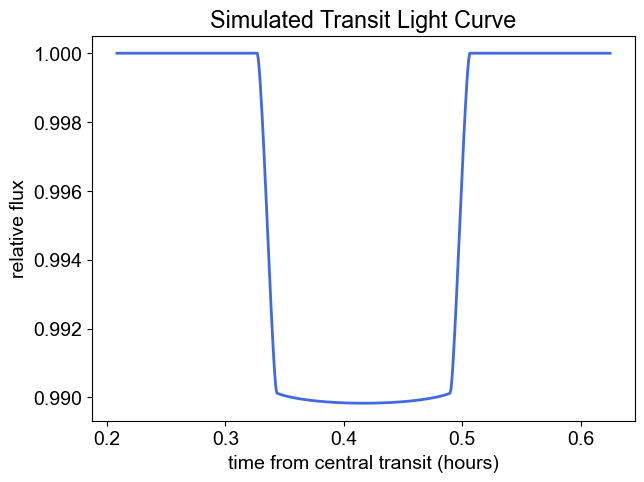

In [2]:
import batman
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
matplotlib.rcParams.update({'font.size':14})

M_s = 1.9885*1e30
m_p = M_s * 0.001
G = 6.67 * 1e-11
T = 10 * (24*60*60)
a = (G*(M_s+m_p)*T**2/(4*np.pi**2))**(1/3)
R_s = 6.96e8  # Stellar radius in meters
a = a / R_s  # Convert semi-major axis to stellar radii

params = batman.TransitParams()         #object to store transit parameters
params.t0 = 10/24.             # mid transit point
params.per = 10.             #orbital period
params.rp = 0.1             #planet radius (in units of stellar radii)
params.a = a              #semi-major axis (in units of stellar radii)
params.inc = 90            #orbital inclination (in degrees)
params.ecc = 0.             #eccentricity
params.w = 90.              #longitude of periastron (in degrees)
params.limb_dark = "quadratic"          #limb darkening model
params.u = [.05,0]        #limb darkening coefficients
   
#t = np.linspace(-0.025, 0.025, 1000)   #times at which to calculate light curve	
t = np.loadtxt('times.txt')
t = t[0]/24
#t = np.linspace(-.25, .25, 1000)

m = batman.TransitModel(params, t)      #initializes model

flux = m.light_curve(params)       #calculates light curve

fig, ax = plt.subplots(figsize=[7, 5])
ax.plot(t, flux,color='royalblue',lw=2, label="Transit light curve")
ax.set_xlabel('time from central transit (hours)')
ax.set_ylabel('relative flux')
ax.set_title('Simulated Transit Light Curve')
#m = batman.TransitModel(params, t, supersample_factor = 7, exp_time = 0.001)

# Part I: MCMC modelling of the single planet transit

### Below is the mcmc code that we wrote to find the best-fit parameters for the transit of a single planet around its host star. Here we fit for T, Rp/Rs, a/Rs, and the limb darkening coefficients.

In [3]:
import corner
import batman as bm
import numpy as np
from matplotlib import pyplot as plt
import time
import matplotlib as mpl
from tqdm import trange
mpl.rcParams['figure.dpi'] = 300

global ld_type
ld_type = 'quadratic'

global inc
global ecc
global w

global P
P = 10


inc = 90
ecc = 0.0
w = 90

np.random.seed(42)


def get_transit(pars, t):
    pars = np.array(pars, dtype=float)
    params = bm.TransitParams()  # object to store transit parameters
    params.t0 = pars[0]  # mid-transit point
    params.per = P  # orbital period
    params.rp = pars[1]  # planet radius (in units of stellar radii)
    params.a = pars[2]  # semi-major axis (in units of stellar radii)
    params.inc = inc  # orbital inclination (in degrees)
    params.ecc = ecc  # eccentricity
    params.w = w  # longitude of periastron (in degrees)
    params.u = pars[3:5]  # limb darkening coefficients
    params.limb_dark = ld_type  # limb darkening model

    model = bm.TransitModel(params, t)  # initializes model
    light_curve = model.light_curve(params)  # calculates light curve

    return light_curve


def chisq(pars, data, t, Ninv):
    if pars[3]<0 or pars[4]<0:
        return np.inf
    else: 
        y = get_transit(pars, t)
        r = data-y
        chisq = r@Ninv@r
        return chisq


def run_chain(pars, fun, data, t, Ninv, L, nsamp=100, adapt_steps=10, target_acceptance=0.45):
    chisq = np.zeros(nsamp)
    npar = len(pars)
    chain = np.zeros([nsamp, npar])
    chain[0, :] = pars
    chisq[0] = fun(pars, data, t, Ninv)
    acceptance_count = 0  # Track acceptance count
    step_size = L  # Initialize step size

    for i in trange(1, nsamp):
        pnew = chain[i - 1, :] + step_size * np.random.randn(npar)
        chi_new = fun(pnew, data, t, Ninv)
        prob = np.exp(0.5 * (chisq[i - 1] - chi_new))

        if np.random.rand() < prob:  # Accept step
            chain[i, :] = pnew
            chisq[i] = chi_new
            acceptance_count += 1
        else:  # Reject step
            chain[i, :] = chain[i - 1, :]
            chisq[i] = chisq[i - 1]

#         # Adjust step size every `adapt_steps` iterations
        if i % adapt_steps == 0:
            acceptance_rate = acceptance_count / adapt_steps
            #print(acceptance_rate)
            if acceptance_rate < target_acceptance:
                step_size *= 0.5  # Decrease step size
            elif acceptance_rate > target_acceptance:
                step_size *= 1.5  # Increase step size
            acceptance_count = 0  # Reset acceptance count

    return chain, chisq


times = np.loadtxt('times.txt')
t = times[0] / 24
lc_observed = np.loadtxt('lightcurve.txt')
flux = lc_observed[0]
errs = np.zeros(len(flux))+1.0e-3

# set initial parameters
titles = ['T0', 'Rp/Rs',
          'a/Rs',  'u1', 'u2']
real = np.asarray([10/24,  0.1, 19.5177,  0.4, 0.1])
pguess = np.asarray([0.4,  0.08, 10,  0.0, 0.0])  # input

# L = pguess*[1e-2, 1e-2, 1e-2, 1e-3, 1e-3]
L = pguess*5e-3
L[-2] = 0.001
L[-1] = 0.001
# L = np.array([0.005, 0.05, 0.005, 0.005, 0.05, 0.001, 0.05, 0.005, 0.005])*1e-1


Ninv = np.diag(1/errs**2)

# %%
nsamp = 200000
burnin = 150000

chain, chivec = run_chain(pguess, chisq, flux, t, Ninv,
                          L=L, nsamp=nsamp)
chain = chain[burnin:, :]
chivec = chivec[burnin:]

# %%


steps = np.arange(0, nsamp)
steps = steps[burnin:]
# Number of parameters
n_params = len(titles)


100%|█████████████████████████████████| 199999/199999 [00:24<00:00, 8090.46it/s]


### Trace plots for each parameter to check for convergence:

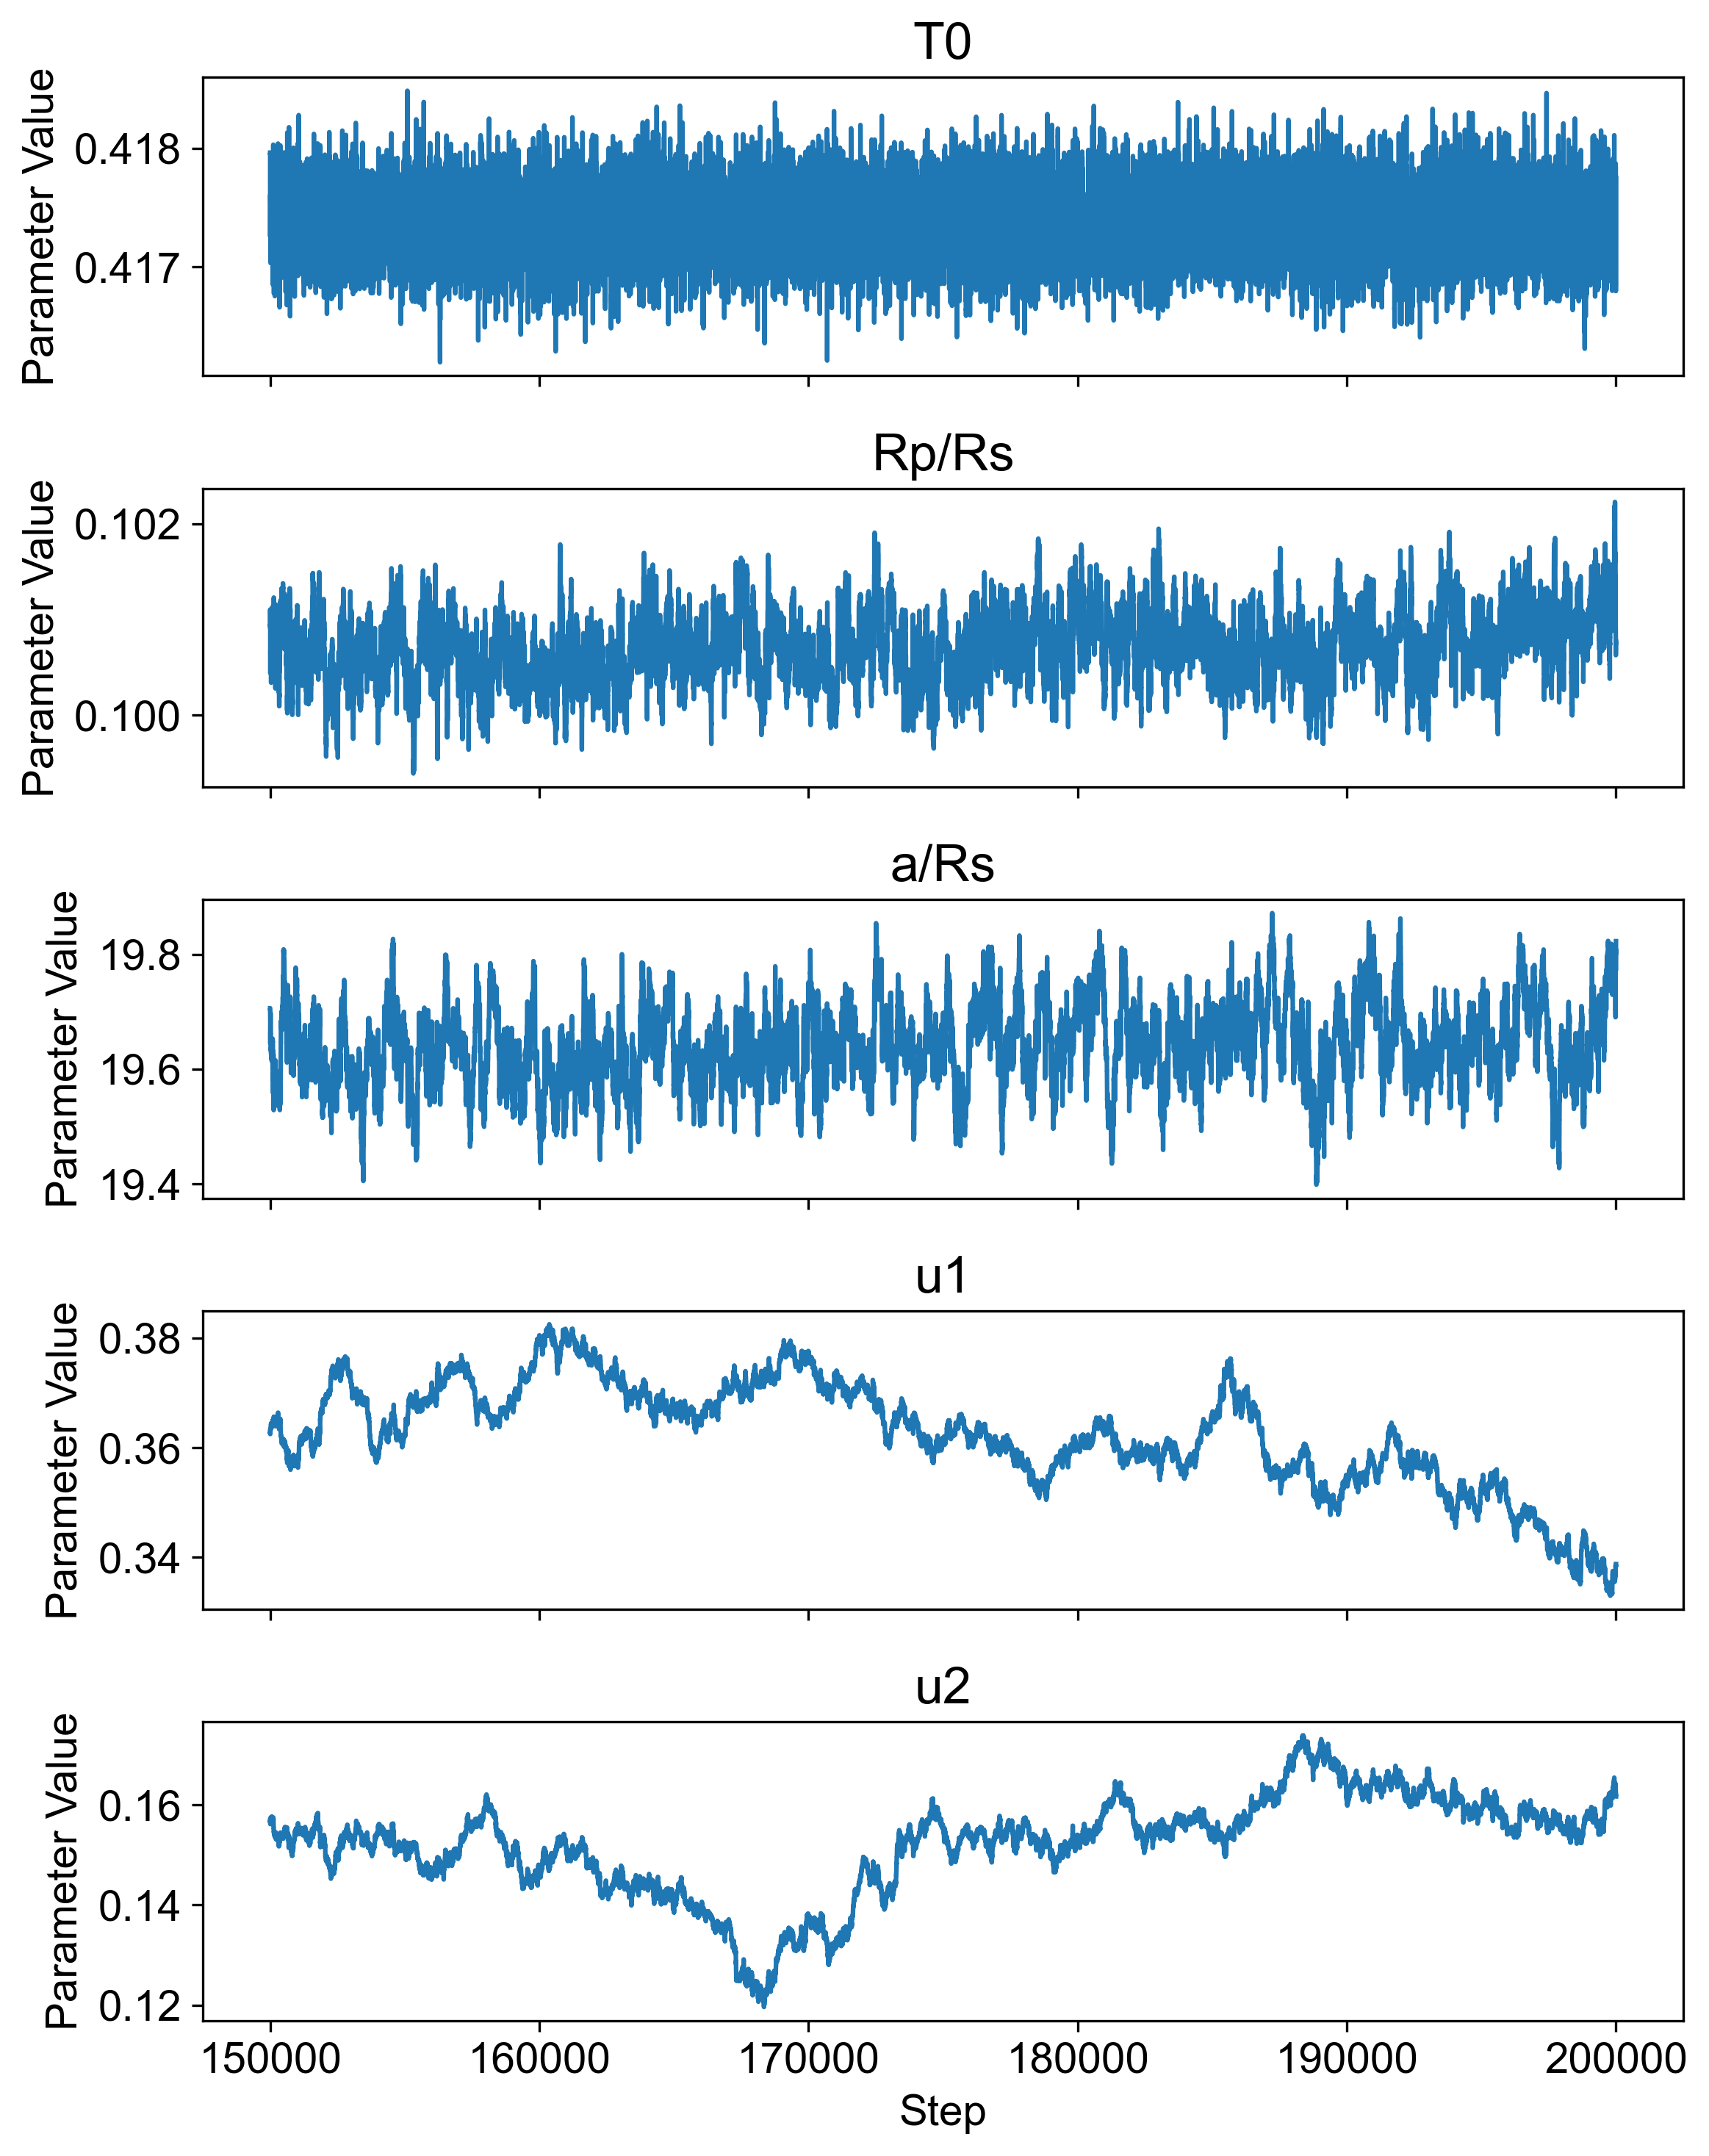

In [4]:
# Create a figure and subplots stacked vertically
fig, axes = plt.subplots(n_params, 1, figsize=(8, 2 * n_params), sharex=True)

# Plot each parameter chain on its corresponding subplot
for i, ax in enumerate(axes):
    ax.plot(steps, chain[:, i])  # Plot for the i-th parameter
    ax.set_title(titles[i])
    ax.set_ylabel("Parameter Value")

# Label the x-axis only on the bottom plot
axes[-1].set_xlabel("Step")

# Adjust the layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()


### As evidenced by the trace plots, our MCMC converged well around the true parameter values. The first three parameters mentioned converged quickly—within just 2000 steps (we checked this by playing around with nsamp). However, we nonetheless used substantial burn-in in order to account for the fact that the limb darkening coefficients were a bit harder to constrain and not as well converged.


#### Initial Guess: [0.4,          0.08,      10,            0.0,          0.0] 
#### Best-fit:         [ 0.41738,  0.10071, 19.63941,  0.36258,  0.152  ]
#### True:              [ 0.41667,  0.1,          19.5177,    0.4,           0.1    ]

### Corner plots to check covariances between parameters:

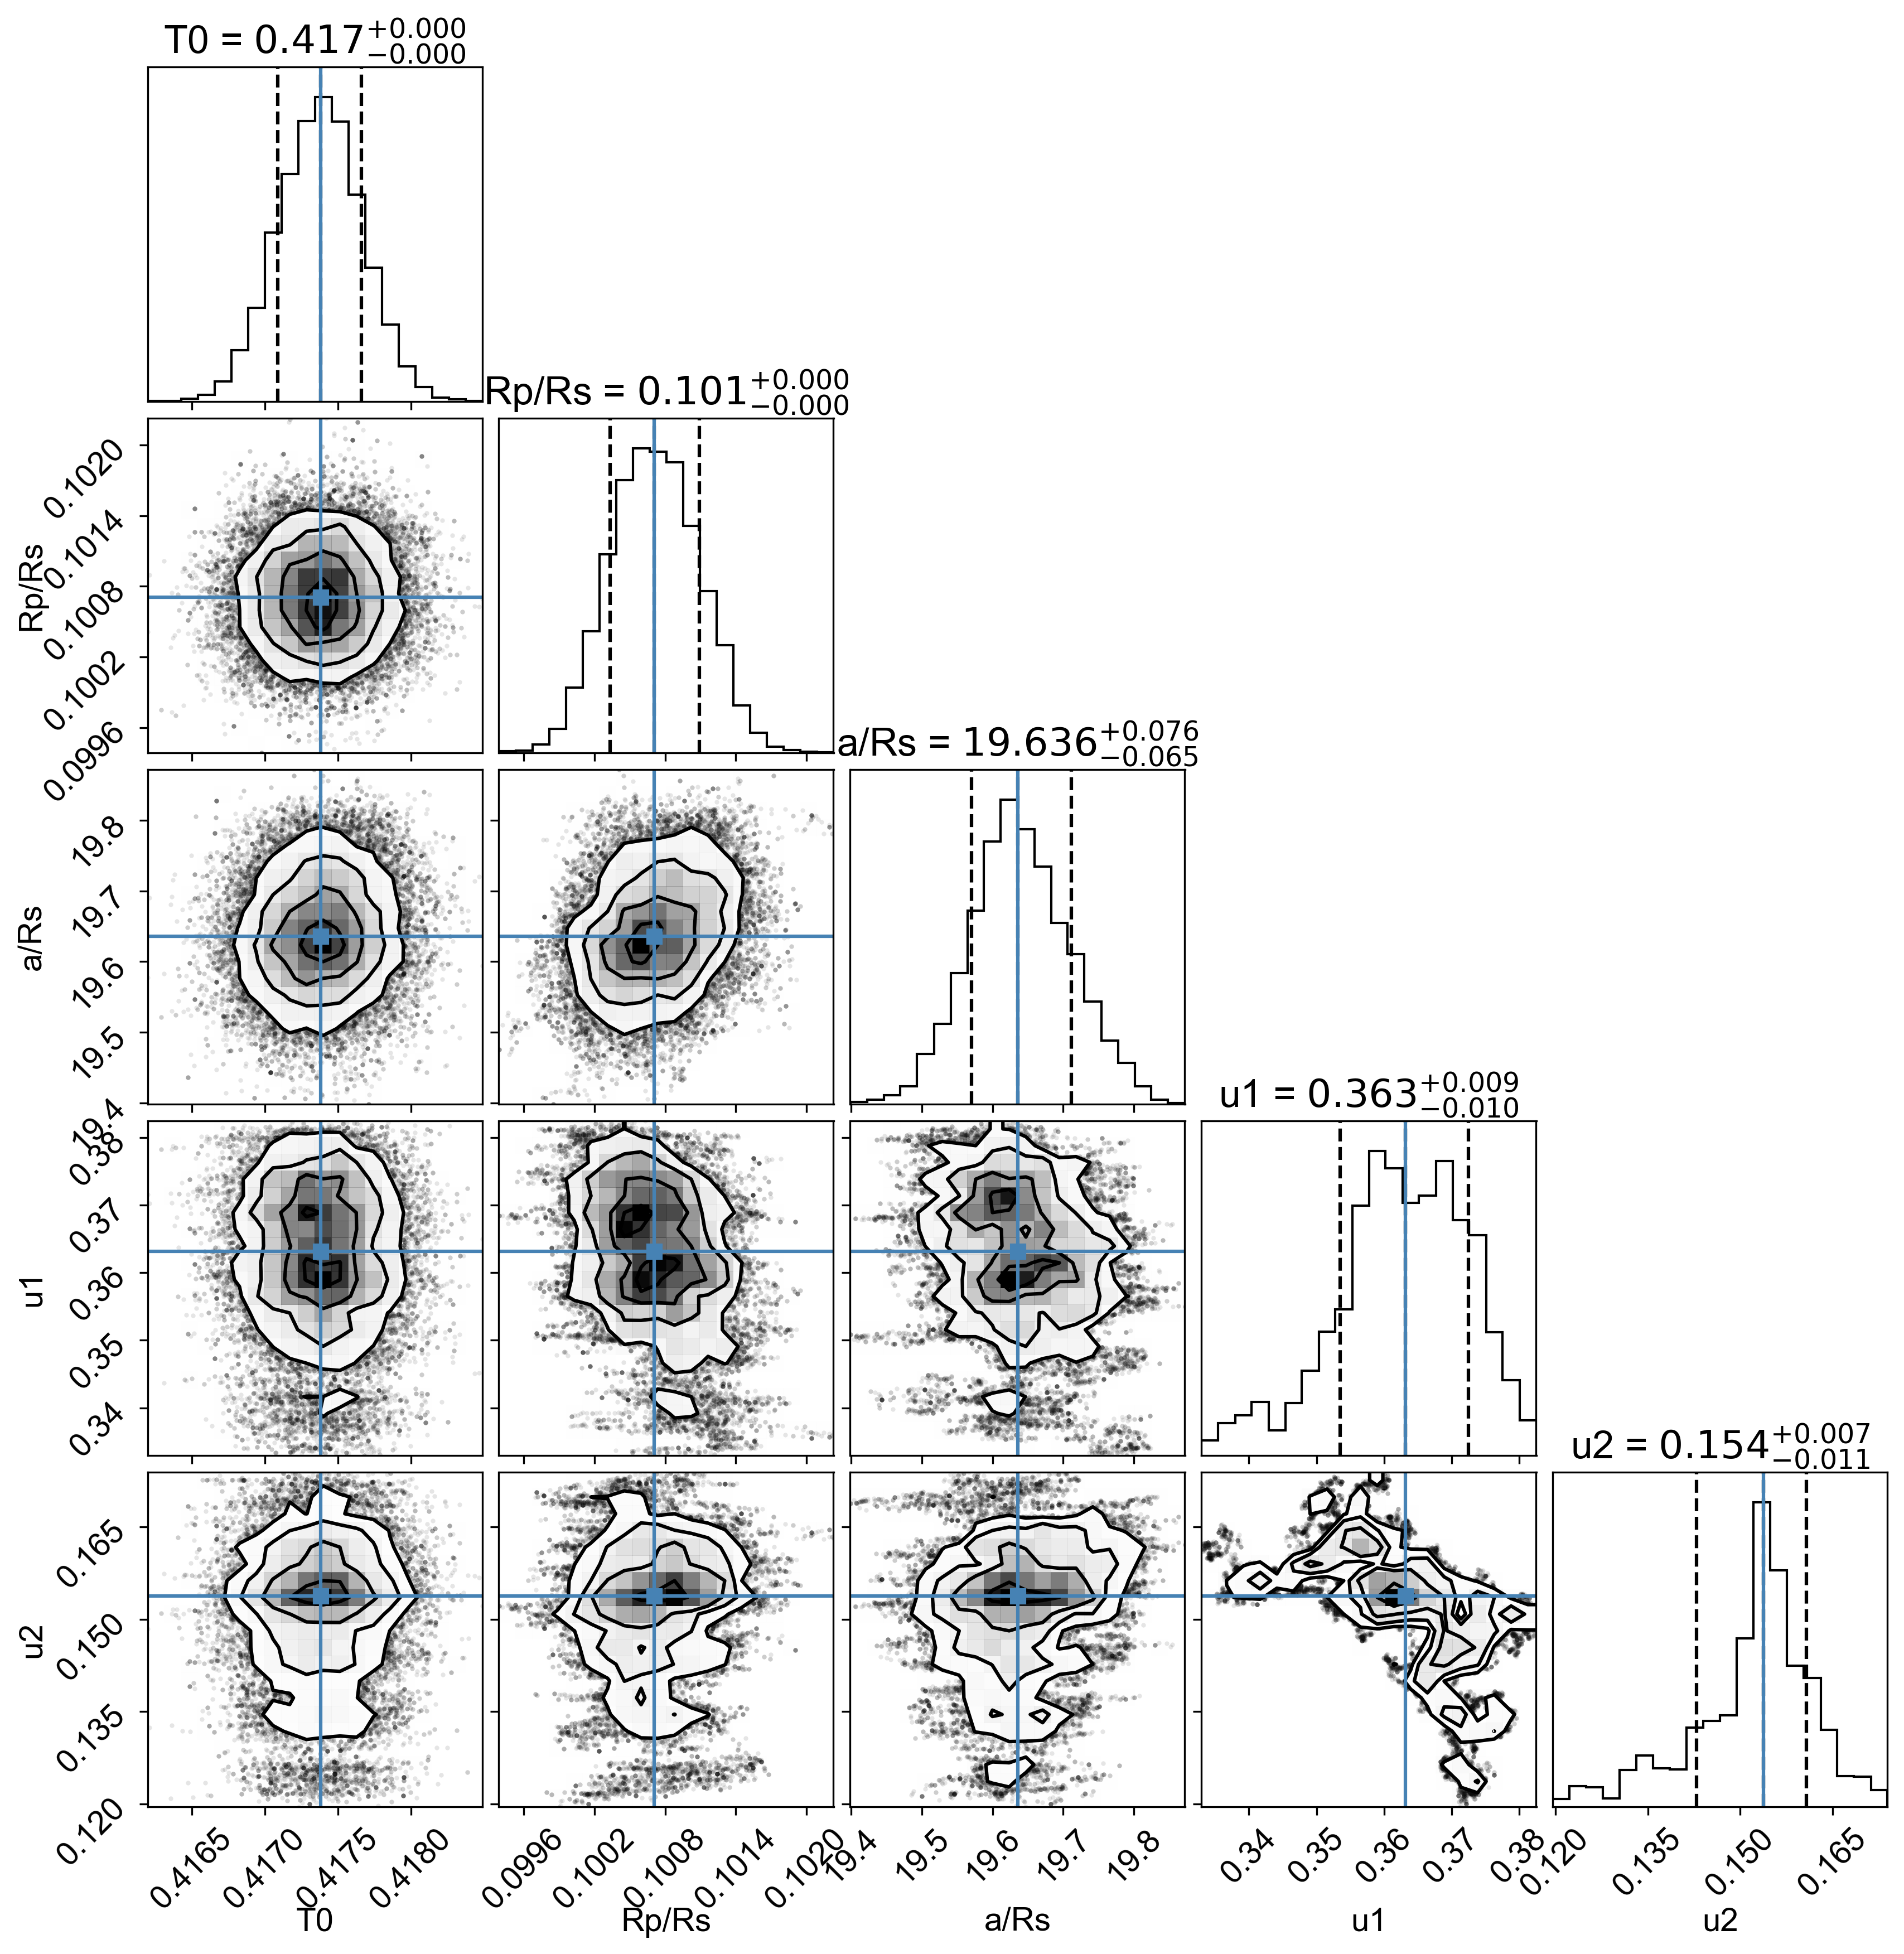

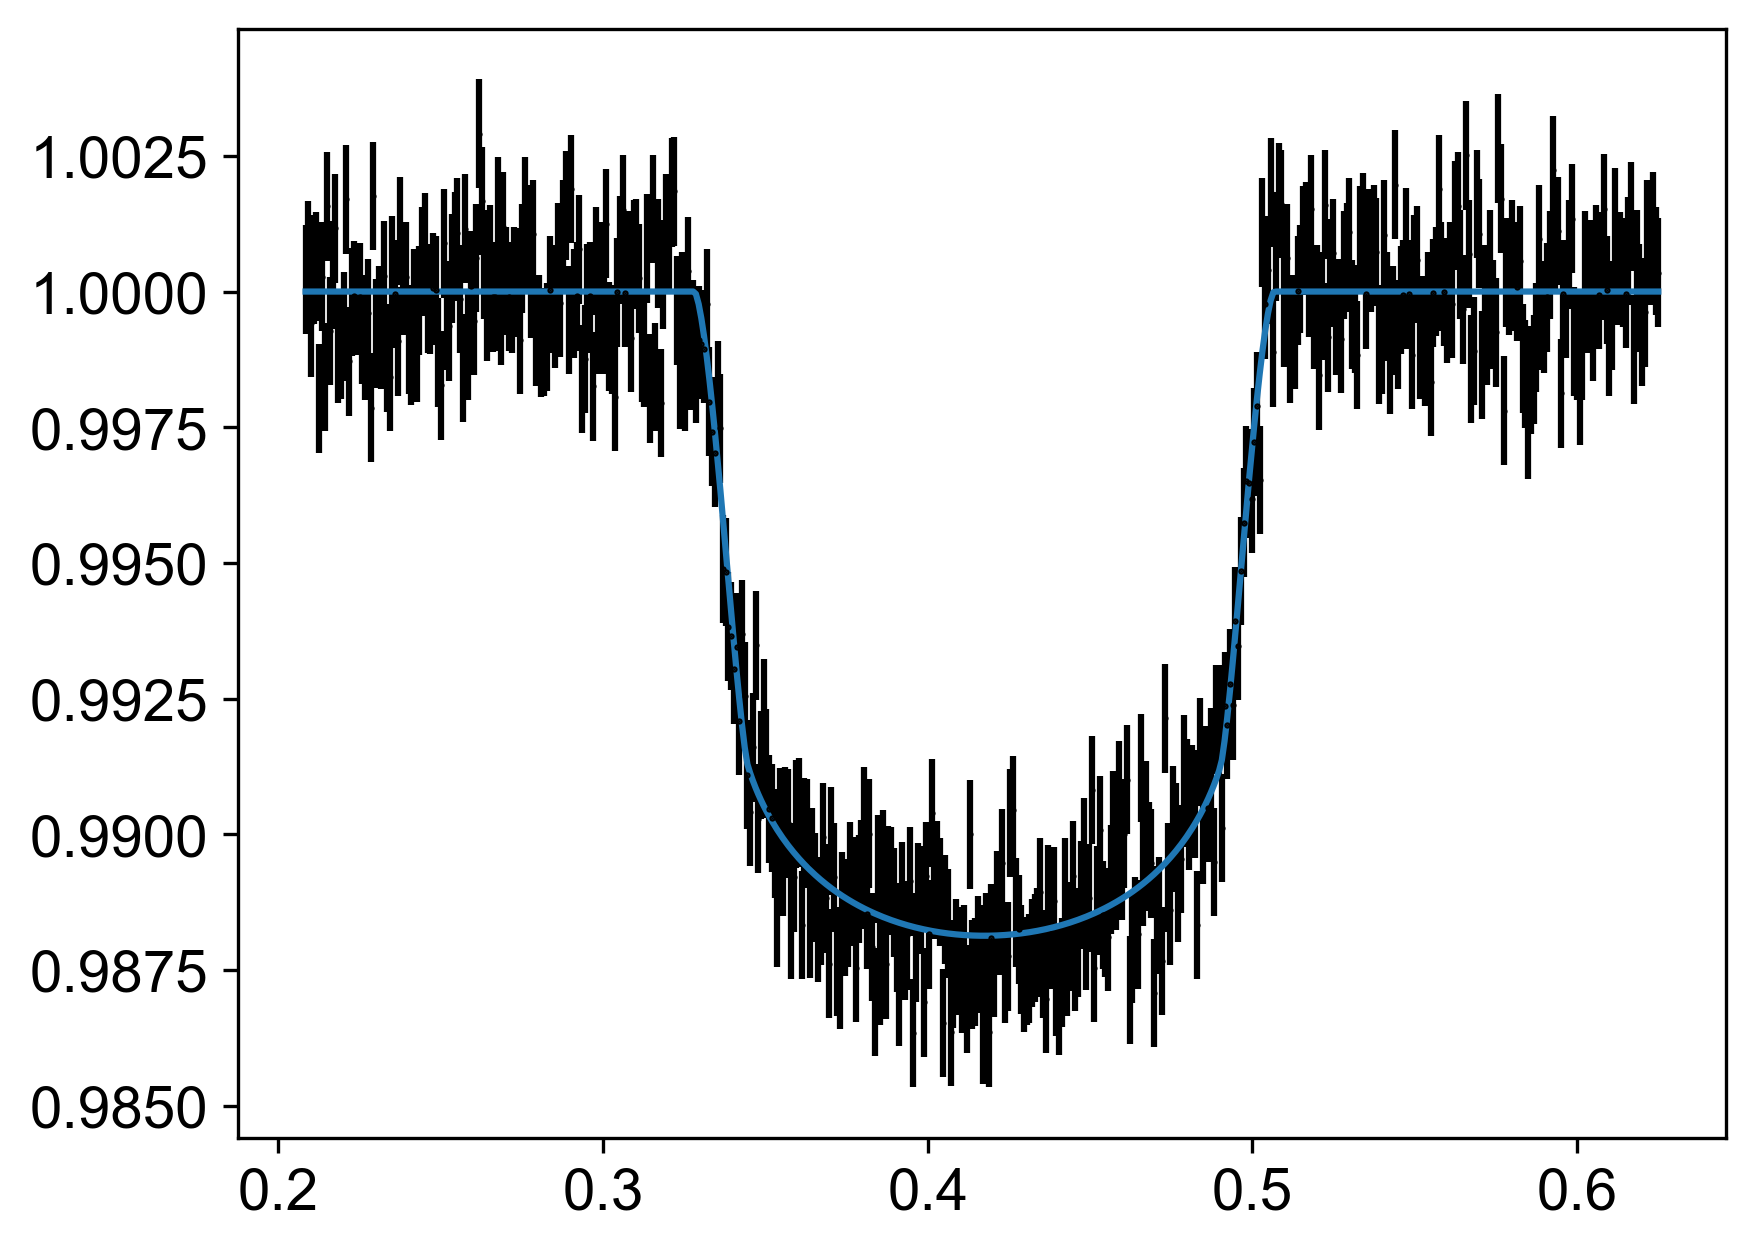

In [155]:
# Create a corner plot
fig = corner.corner(chain, labels=titles, truths=np.median(
    chain, axis=0), quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.3f', )

# Show the plot
plt.show()

plt.errorbar(t, flux, errs, fmt='.', c='k', markersize=1)
plt.plot(t, get_transit(np.mean(chain, axis=0), t))
plt.show()

### The corner plots—which show distributions for each parameter along the diagonal and the covariances between them underneath—also indicate a strong fit. The generally circular nature of the covariances implies that the parameters are uncorrelated. This is good because when parameters are uncorrelated, MCMC sampling is more efficient and more capable of exploring the parameter space adequately.

### Yet, most importantly, to assess the strength of any fit the chi-squared value is the best indicator. The goodness of fit test involves dividing the chi-squared value by the degrees of freedom (defined as len(resid)-len(pars) as we saw in HW #4). The "goodness" is based on how close that ratio is to 1. In our case, given the above noted definition, there were 495 degrees of freedom for a chi-squared value of 483.8. Their ratio chisq/(d.o.f) is .98 indicating a very good fit.

In [156]:
print('chi-square: ', sum(((flux-get_transit(np.mean(chain, axis=0), t))**2.)/(errs**2.)))

chi-square:  483.83221874299625


### One more thing we would like to note is the incorporation of a step size adjustment section in our mcmc chain function. This involved utilizing a variable named ‘adapt_steps,’ which we arbitrarily set to 10 for our run. Every 10 samples we adjusted the step size to improve the acceptance rate of our new parameters and chi-squared values and ensure a strong fit. If the acceptance rate was lower than the target rate, we halved the step size so that the parameter space would be explored more thoroughly. Conversely, if the acceptance rate was too large (i.e., above the target) we increased the step size. The inclusion of this block of code made our mcmc dynamic, as it was constantly in a state of improving its sampling.

## Variation in T0

### Here we use mcmc to see how T0 changes through successive transits of a single planet (ie., testing out TTV on single planet). We first plot how the transit changes over time, visualizing the variation in the mid-transit point. We next plot the OC-curve (ie., observed vs calculated) comparing the expected period for a planet transiting with constant period and the situation in which the period changes through time.

In [12]:
T0s = []
T0_errs = []
nsamp = 10000
burnin = 5000
for flux, t in zip(lc_observed, times):
    t = t / 24
    pguess = np.asarray([np.mean(t),  0.1, 19,  0.35, 0.15])
    
    chain, chivec = run_chain(pguess, chisq, flux, t, Ninv,
                              L=L, nsamp=nsamp)
    chain = chain[burnin:, :]

    best_fits = np.mean(chain, axis=0)

    T0s.append(best_fits[0])
    T0_errs.append(np.std(chain[:,0])*24*60)

T0s = np.array(T0s)
T0_errs = np.array(T0_errs)
periods = np.diff(T0s)
expected = [T0s[0] + np.mean(periods) * n for n in range(len(T0s))]
OC = T0s - expected

100%|████████████████████████████████████| 9999/9999 [00:00<00:00, 10648.11it/s]


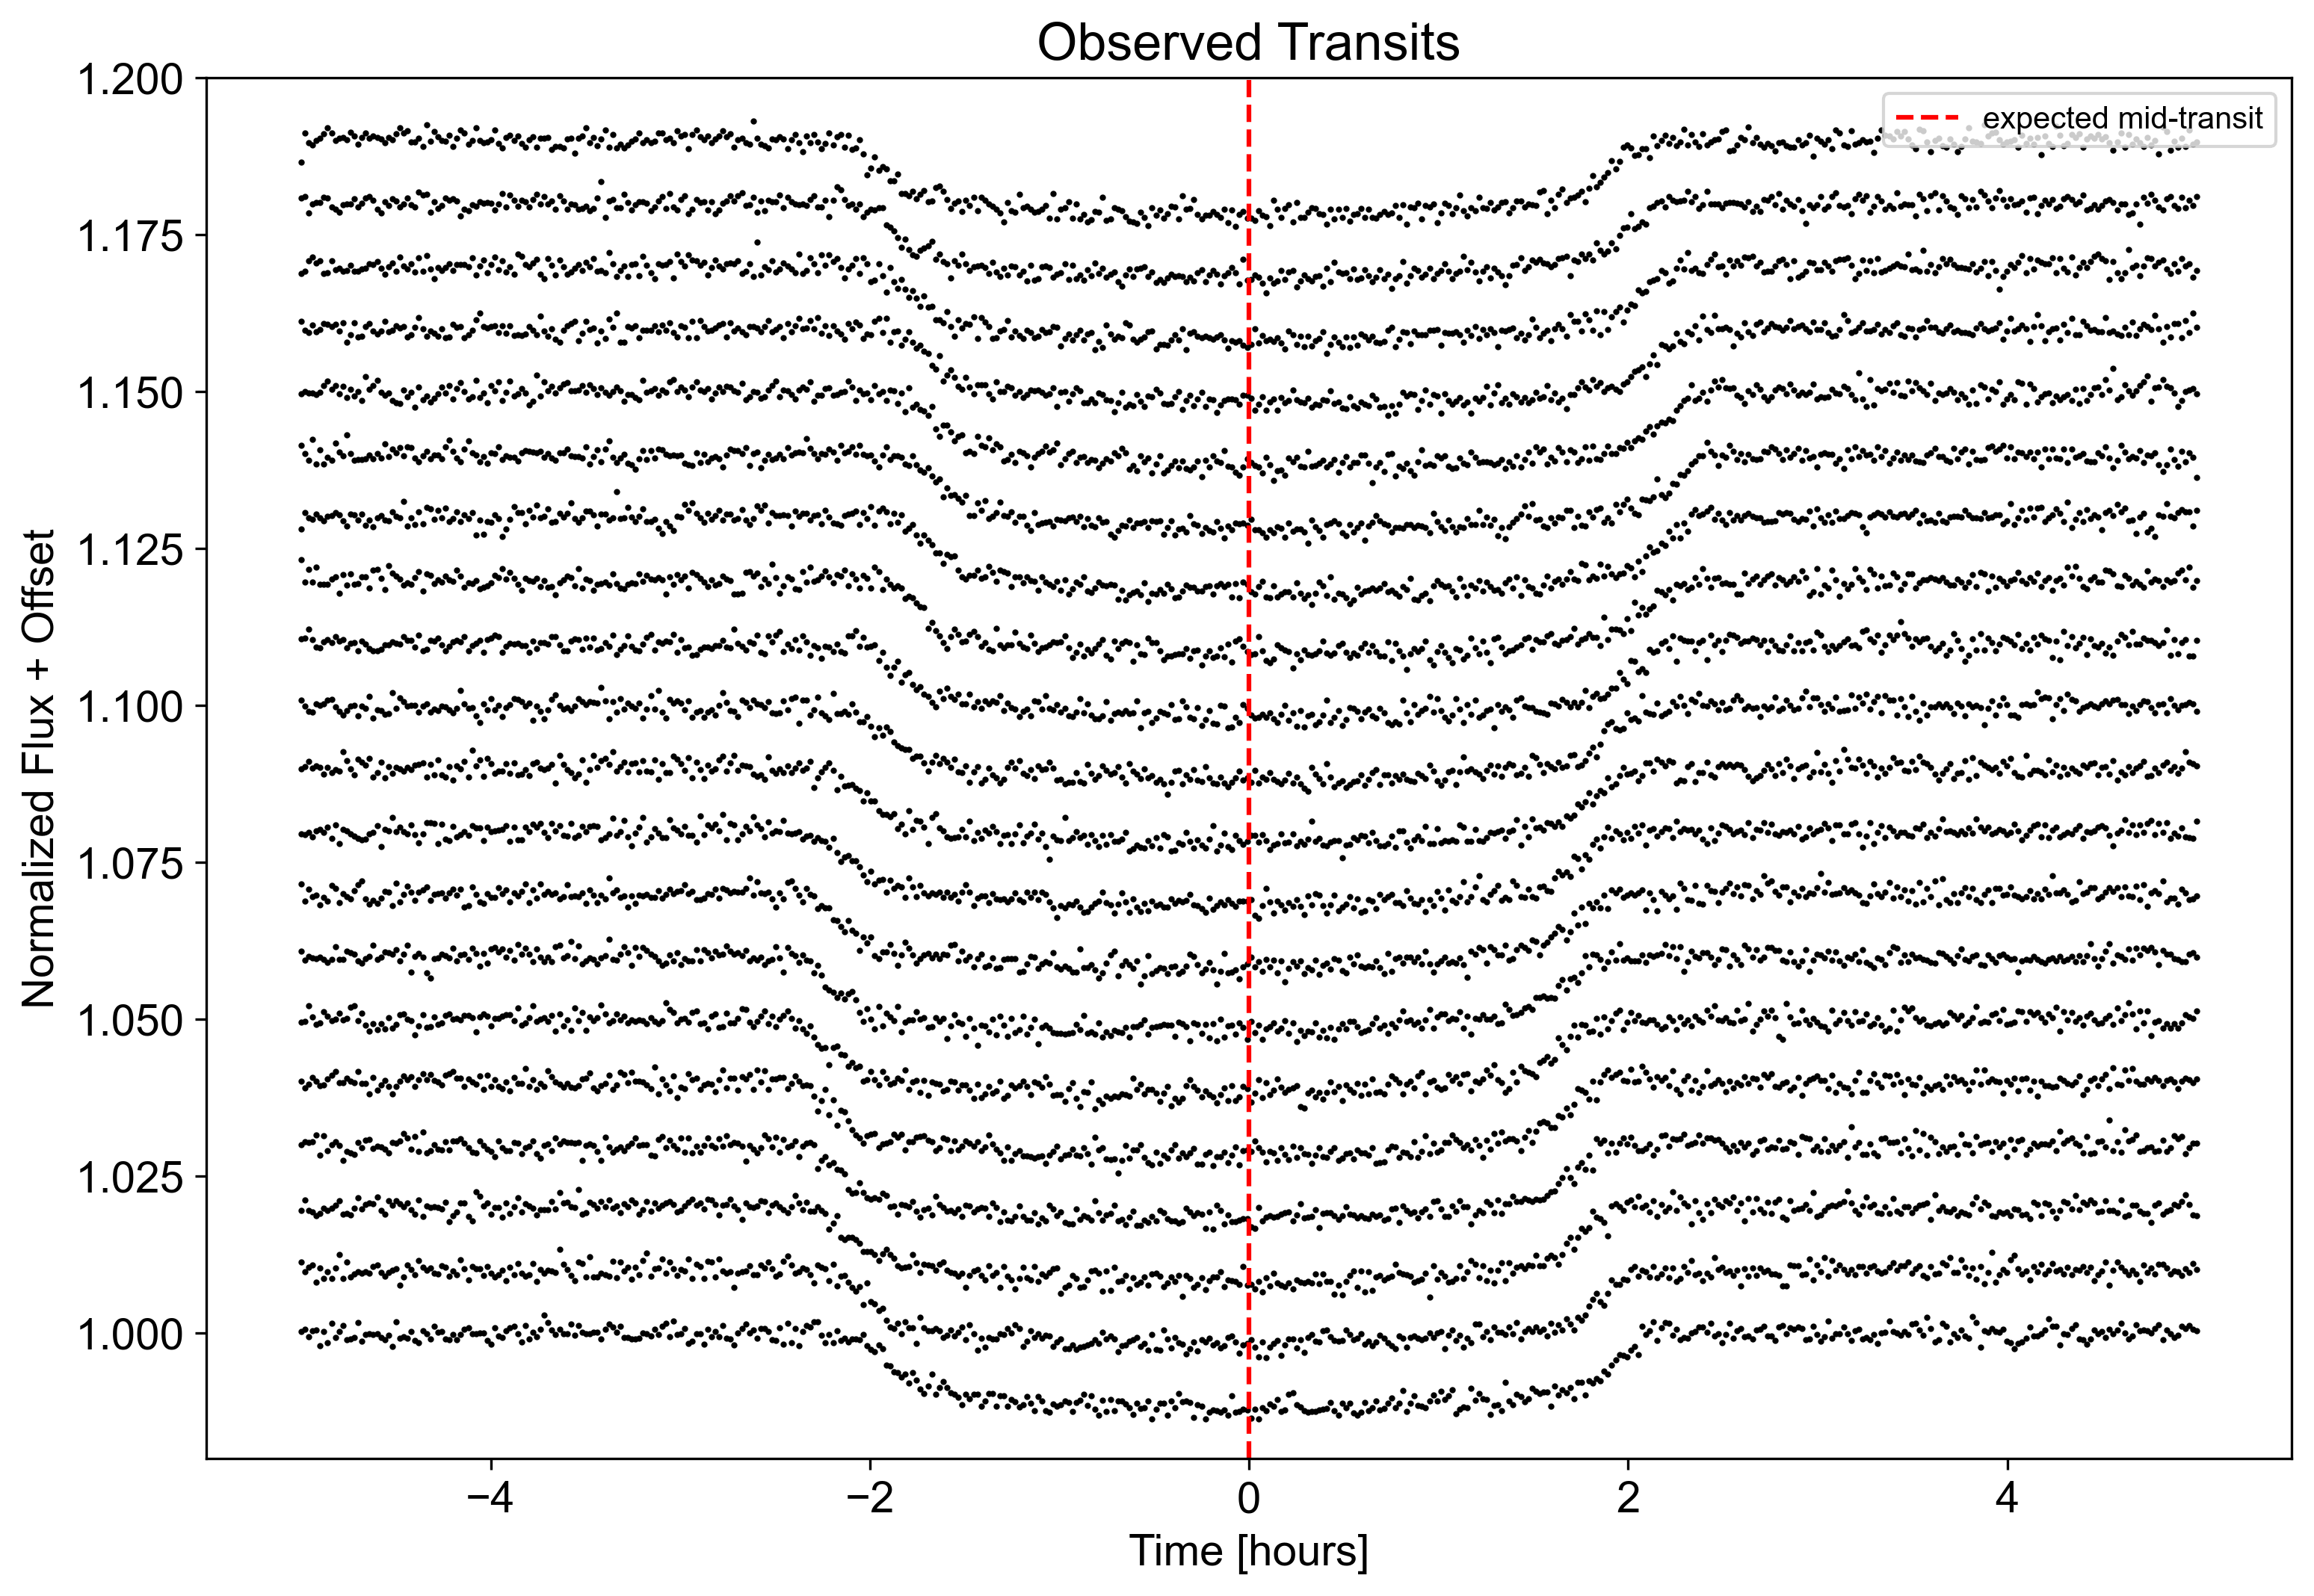

In [9]:
offset_step = 0.01
plt.figure(figsize=(12, 8))
for i, flux in enumerate(lc_observed):
    plt.plot(times[0]-10, flux + i * offset_step, 'k.', ms=2)

plt.vlines(0, 0.98, 1.32, linestyle='--', color='r', label="expected mid-transit")


plt.ylim(0.98, 1.2)
plt.xlabel("Time [hours]", fontsize=14)
plt.ylabel("Normalized Flux + Offset", fontsize=14)
plt.legend(fontsize=10, loc='upper right', ncol=2) 
plt.title("Observed Transits")
plt.show()

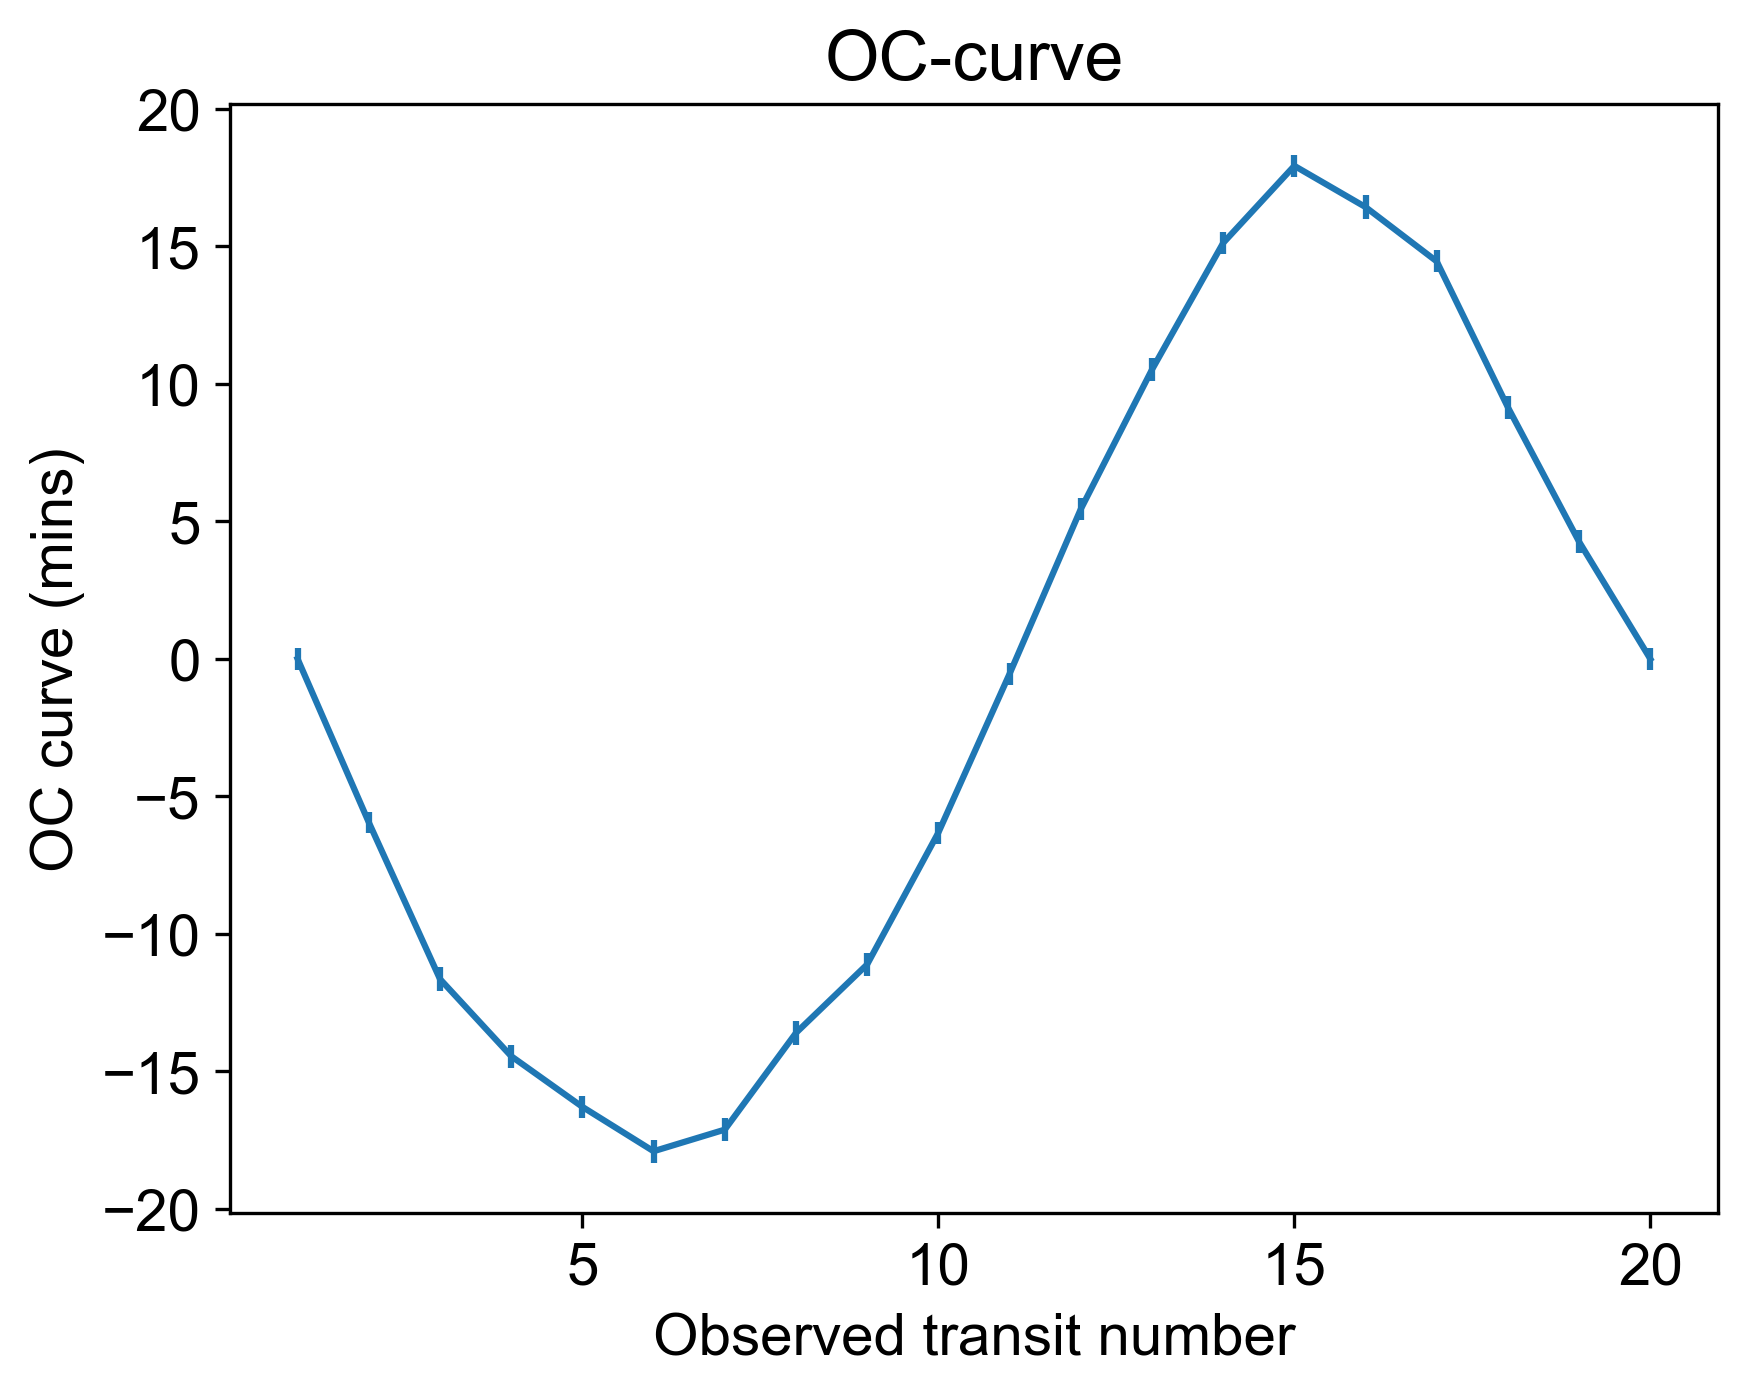

In [8]:
plt.errorbar(arange(1,21), OC*24*60, T0_errs)
plt.xlabel('Observed transit number')
plt.ylabel('OC curve (mins)')
plt.title('OC-curve')
plt.show()

np.savetxt('OC_curve_from_mcmc.txt', np.column_stack([OC*24*60, T0_errs]))

### Here we run mcmc while fixing the limb darkening coefficients (aka only fitting for T, Rp/Rs, a/Rs). Since the coefficients were harder to fit above we wanted to see if anything would change if they were excluded. Our results were the same.

In [206]:

global ld_type
ld_type = 'quadratic'

global inc
global ecc
global w
global u1
global u2

global P
P = 10


inc = 90
ecc = 0.0
w = 90
u1 = 0.4
u2 = 0.1

np.random.seed(42)


def get_transit(pars, t):
    pars = np.array(pars, dtype=float)
    params = bm.TransitParams()  # object to store transit parameters
    params.t0 = pars[0]  # mid-transit point
    params.per = P  # orbital period
    params.rp = pars[1]  # planet radius (in units of stellar radii)
    params.a = pars[2]  # semi-major axis (in units of stellar radii)
    params.inc = inc  # orbital inclination (in degrees)
    params.ecc = ecc  # eccentricity
    params.w = w  # longitude of periastron (in degrees)
    params.u = [u1,u2]  # limb darkening coefficients
    params.limb_dark = ld_type  # limb darkening model

    model = bm.TransitModel(params, t)  # initializes model
    light_curve = model.light_curve(params)  # calculates light curve

    return light_curve


def chisq(pars, data, t, Ninv):
    y = get_transit(pars, t)
    r = data-y
    chisq = r@Ninv@r
    return chisq


def run_chain(pars, fun, data, t, Ninv, L, nsamp=100, adapt_steps=10, target_acceptance=0.45):
    chisq = np.zeros(nsamp)
    npar = len(pars)
    chain = np.zeros([nsamp, npar])
    chain[0, :] = pars
    chisq[0] = fun(pars, data, t, Ninv)
    acceptance_count = 0  # Track acceptance count
    step_size = L  # Initialize step size

    for i in trange(1, nsamp):
        pnew = chain[i - 1, :] + step_size * np.random.randn(npar)
        chi_new = fun(pnew, data, t, Ninv)
        prob = np.exp(0.5 * (chisq[i - 1] - chi_new))

        if np.random.rand() < prob:  # Accept step
            chain[i, :] = pnew
            chisq[i] = chi_new
            acceptance_count += 1
        else:  # Reject step
            chain[i, :] = chain[i - 1, :]
            chisq[i] = chisq[i - 1]

#         # Adjust step size every `adapt_steps` iterations
        if i % adapt_steps == 0:
            acceptance_rate = acceptance_count / adapt_steps
            #print(acceptance_rate)
            if acceptance_rate < target_acceptance:
                step_size *= 0.5  # Decrease step size
            elif acceptance_rate > target_acceptance:
                step_size *= 1.5  # Increase step size
            acceptance_count = 0  # Reset acceptance count

    return chain, chisq


t = np.loadtxt('times.txt')
t = t[0] / 24
lc_observed = np.loadtxt('lightcurve.txt')
flux = lc_observed[0]
errs = np.zeros(len(flux))+1.0e-3

# set initial parameters
titles = ['T0', 'Rp/Rs',
          'a/Rs']
real = np.asarray([10/24,  0.1, 19.5177])
pguess = np.asarray([0.4,  0.08, 10])  # input

# L = pguess*[1e-2, 1e-2, 1e-2, 1e-3, 1e-3]
L = pguess*1e-3
#L[-2] = 0.001
#L[-1] = 0.001
# L = np.array([0.005, 0.05, 0.005, 0.005, 0.05, 0.001, 0.05, 0.005, 0.005])*1e-1


Ninv = np.diag(1/errs**2)

# %%

nsamp = 200000
burnin = 80000


chain, chivec = run_chain(pguess, chisq, flux, t, Ninv,
                          L=L, nsamp=nsamp)
chain = chain[burnin:, :]
chivec = chivec[burnin:]


# %%


steps = np.arange(0, nsamp)
steps = steps[burnin:]
# Number of parameters
n_params = len(titles)


100%|████████████████████████████████████████████████████████████████████████| 199999/199999 [00:37<00:00, 5357.96it/s]


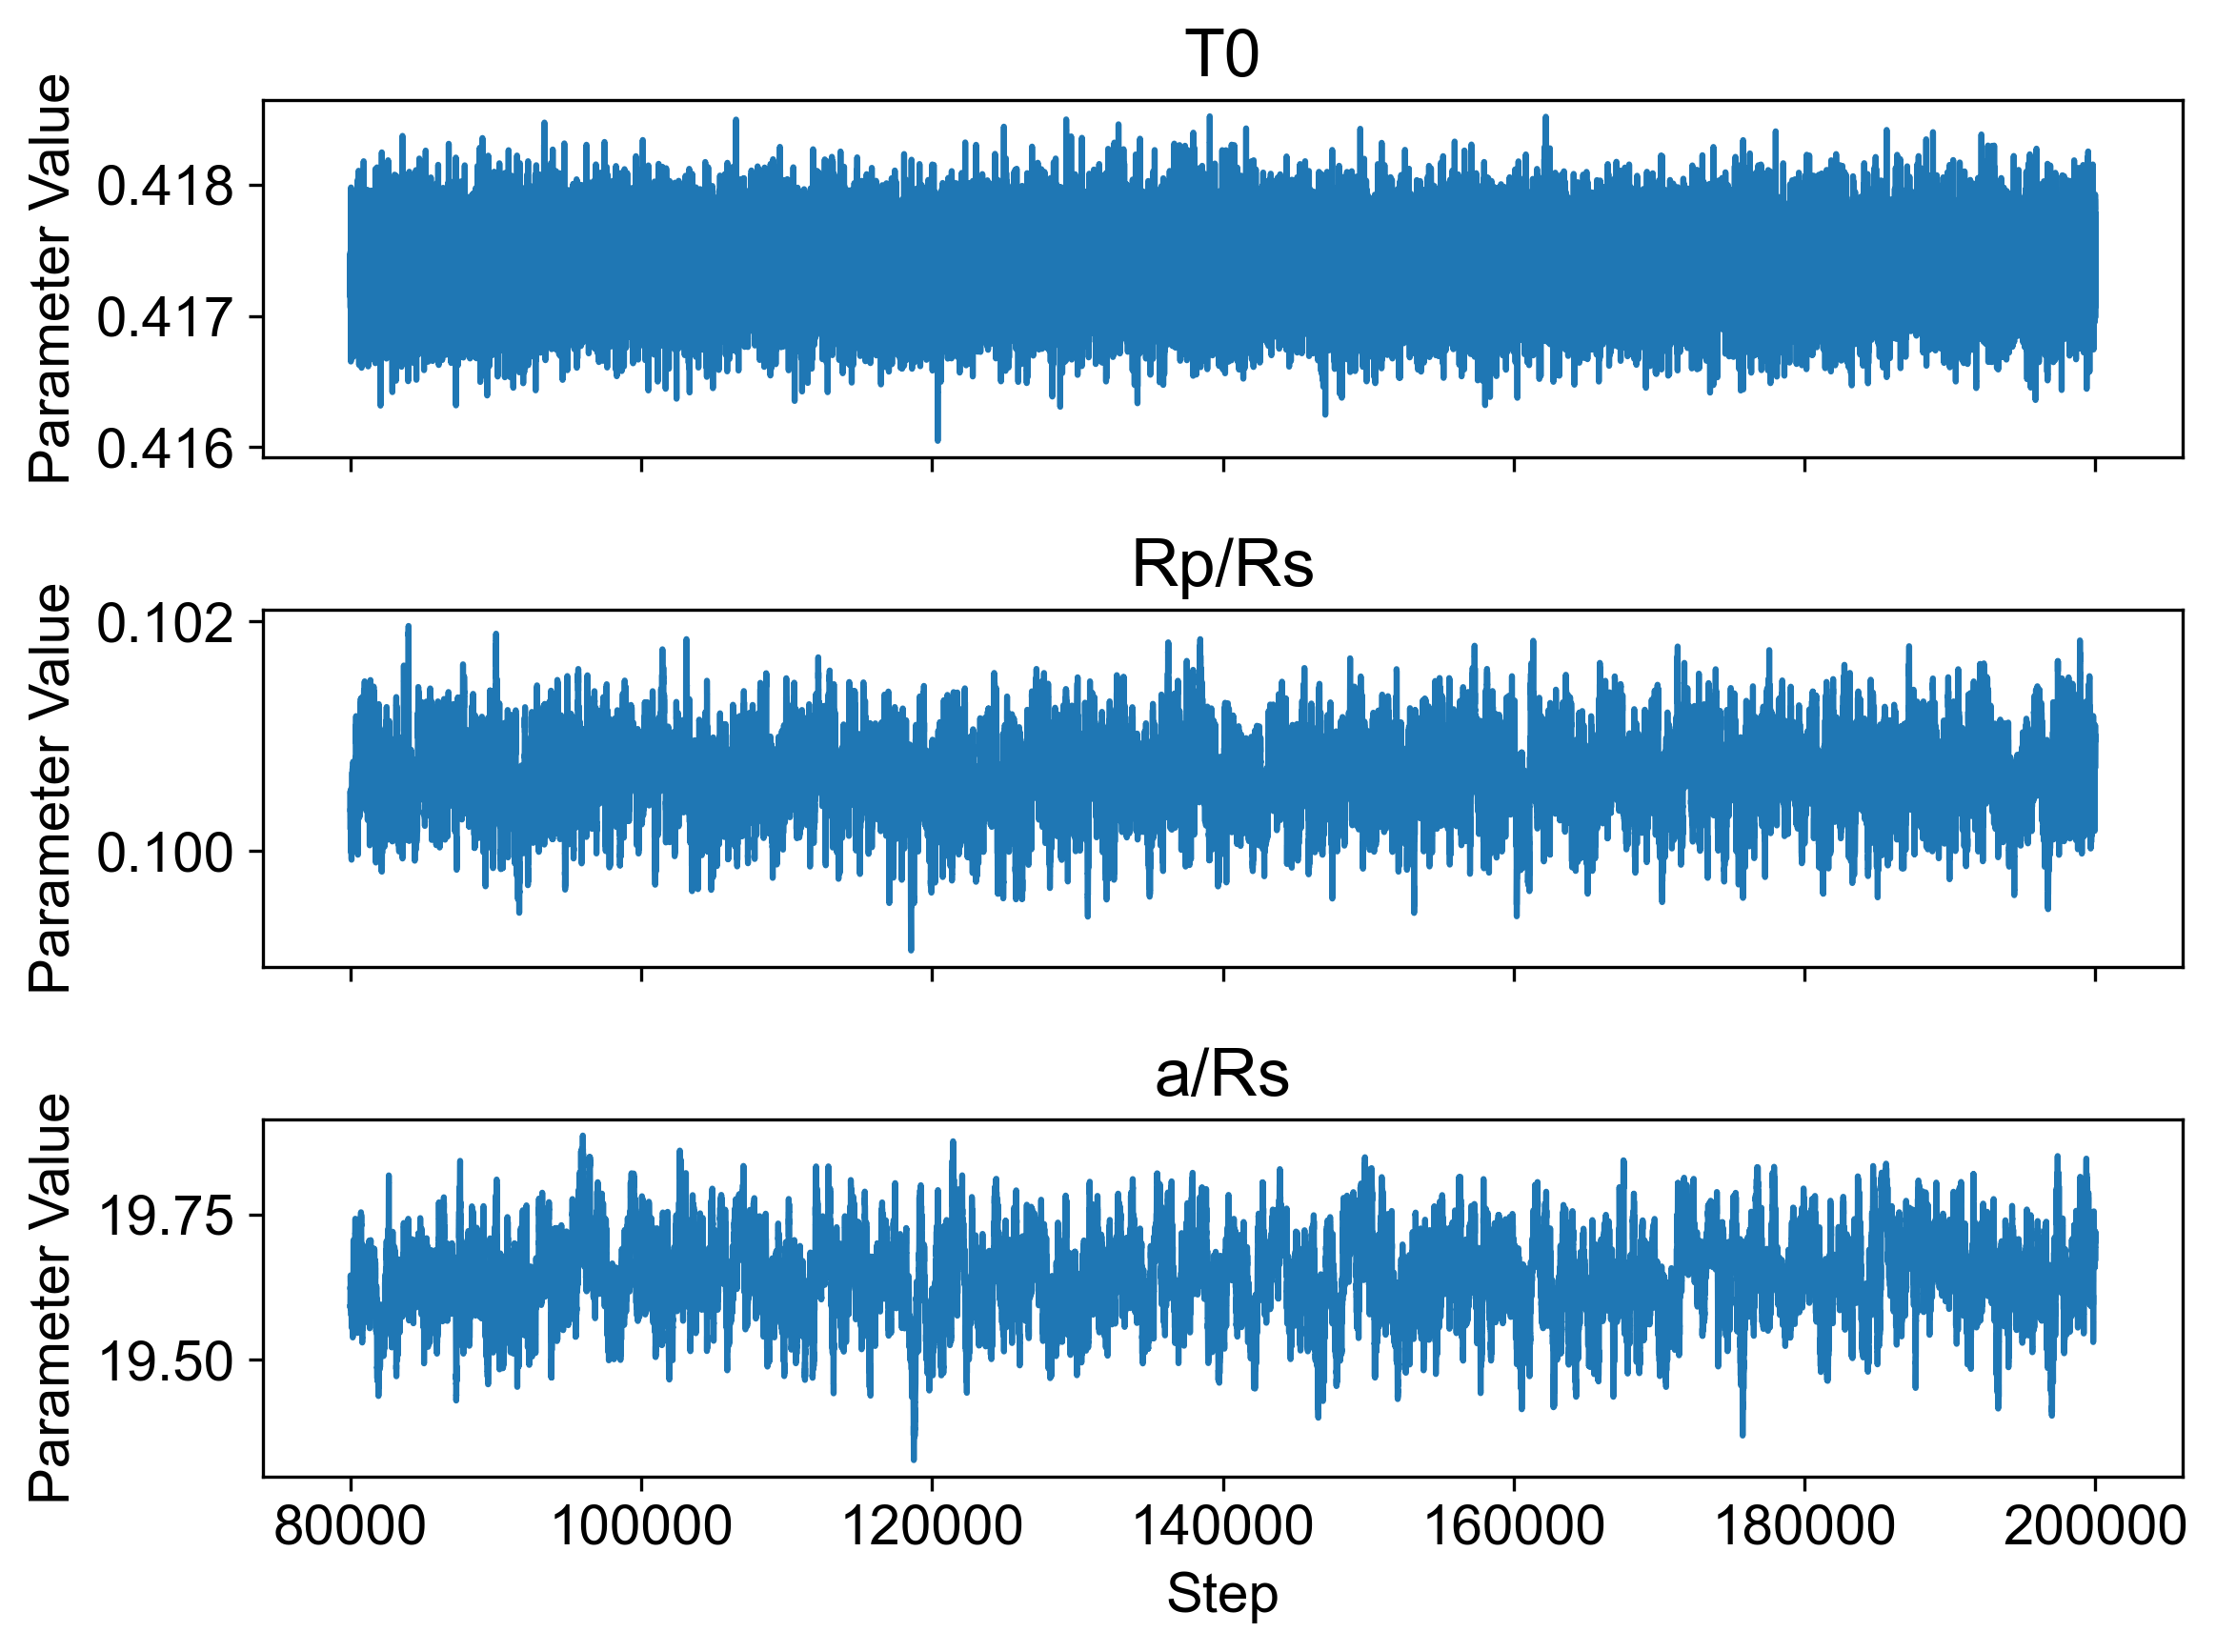

In [208]:
# Create a figure and subplots stacked vertically
fig, axes = plt.subplots(n_params, 1, figsize=(8, 2 * n_params), sharex=True)

# Plot each parameter chain on its corresponding subplot
for i, ax in enumerate(axes):
    ax.plot(steps, chain[:, i])  # Plot for the i-th parameter
    ax.set_title(titles[i])
    ax.set_ylabel("Parameter Value")

# Label the x-axis only on the bottom plot
axes[-1].set_xlabel("Step")

# Adjust the layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()


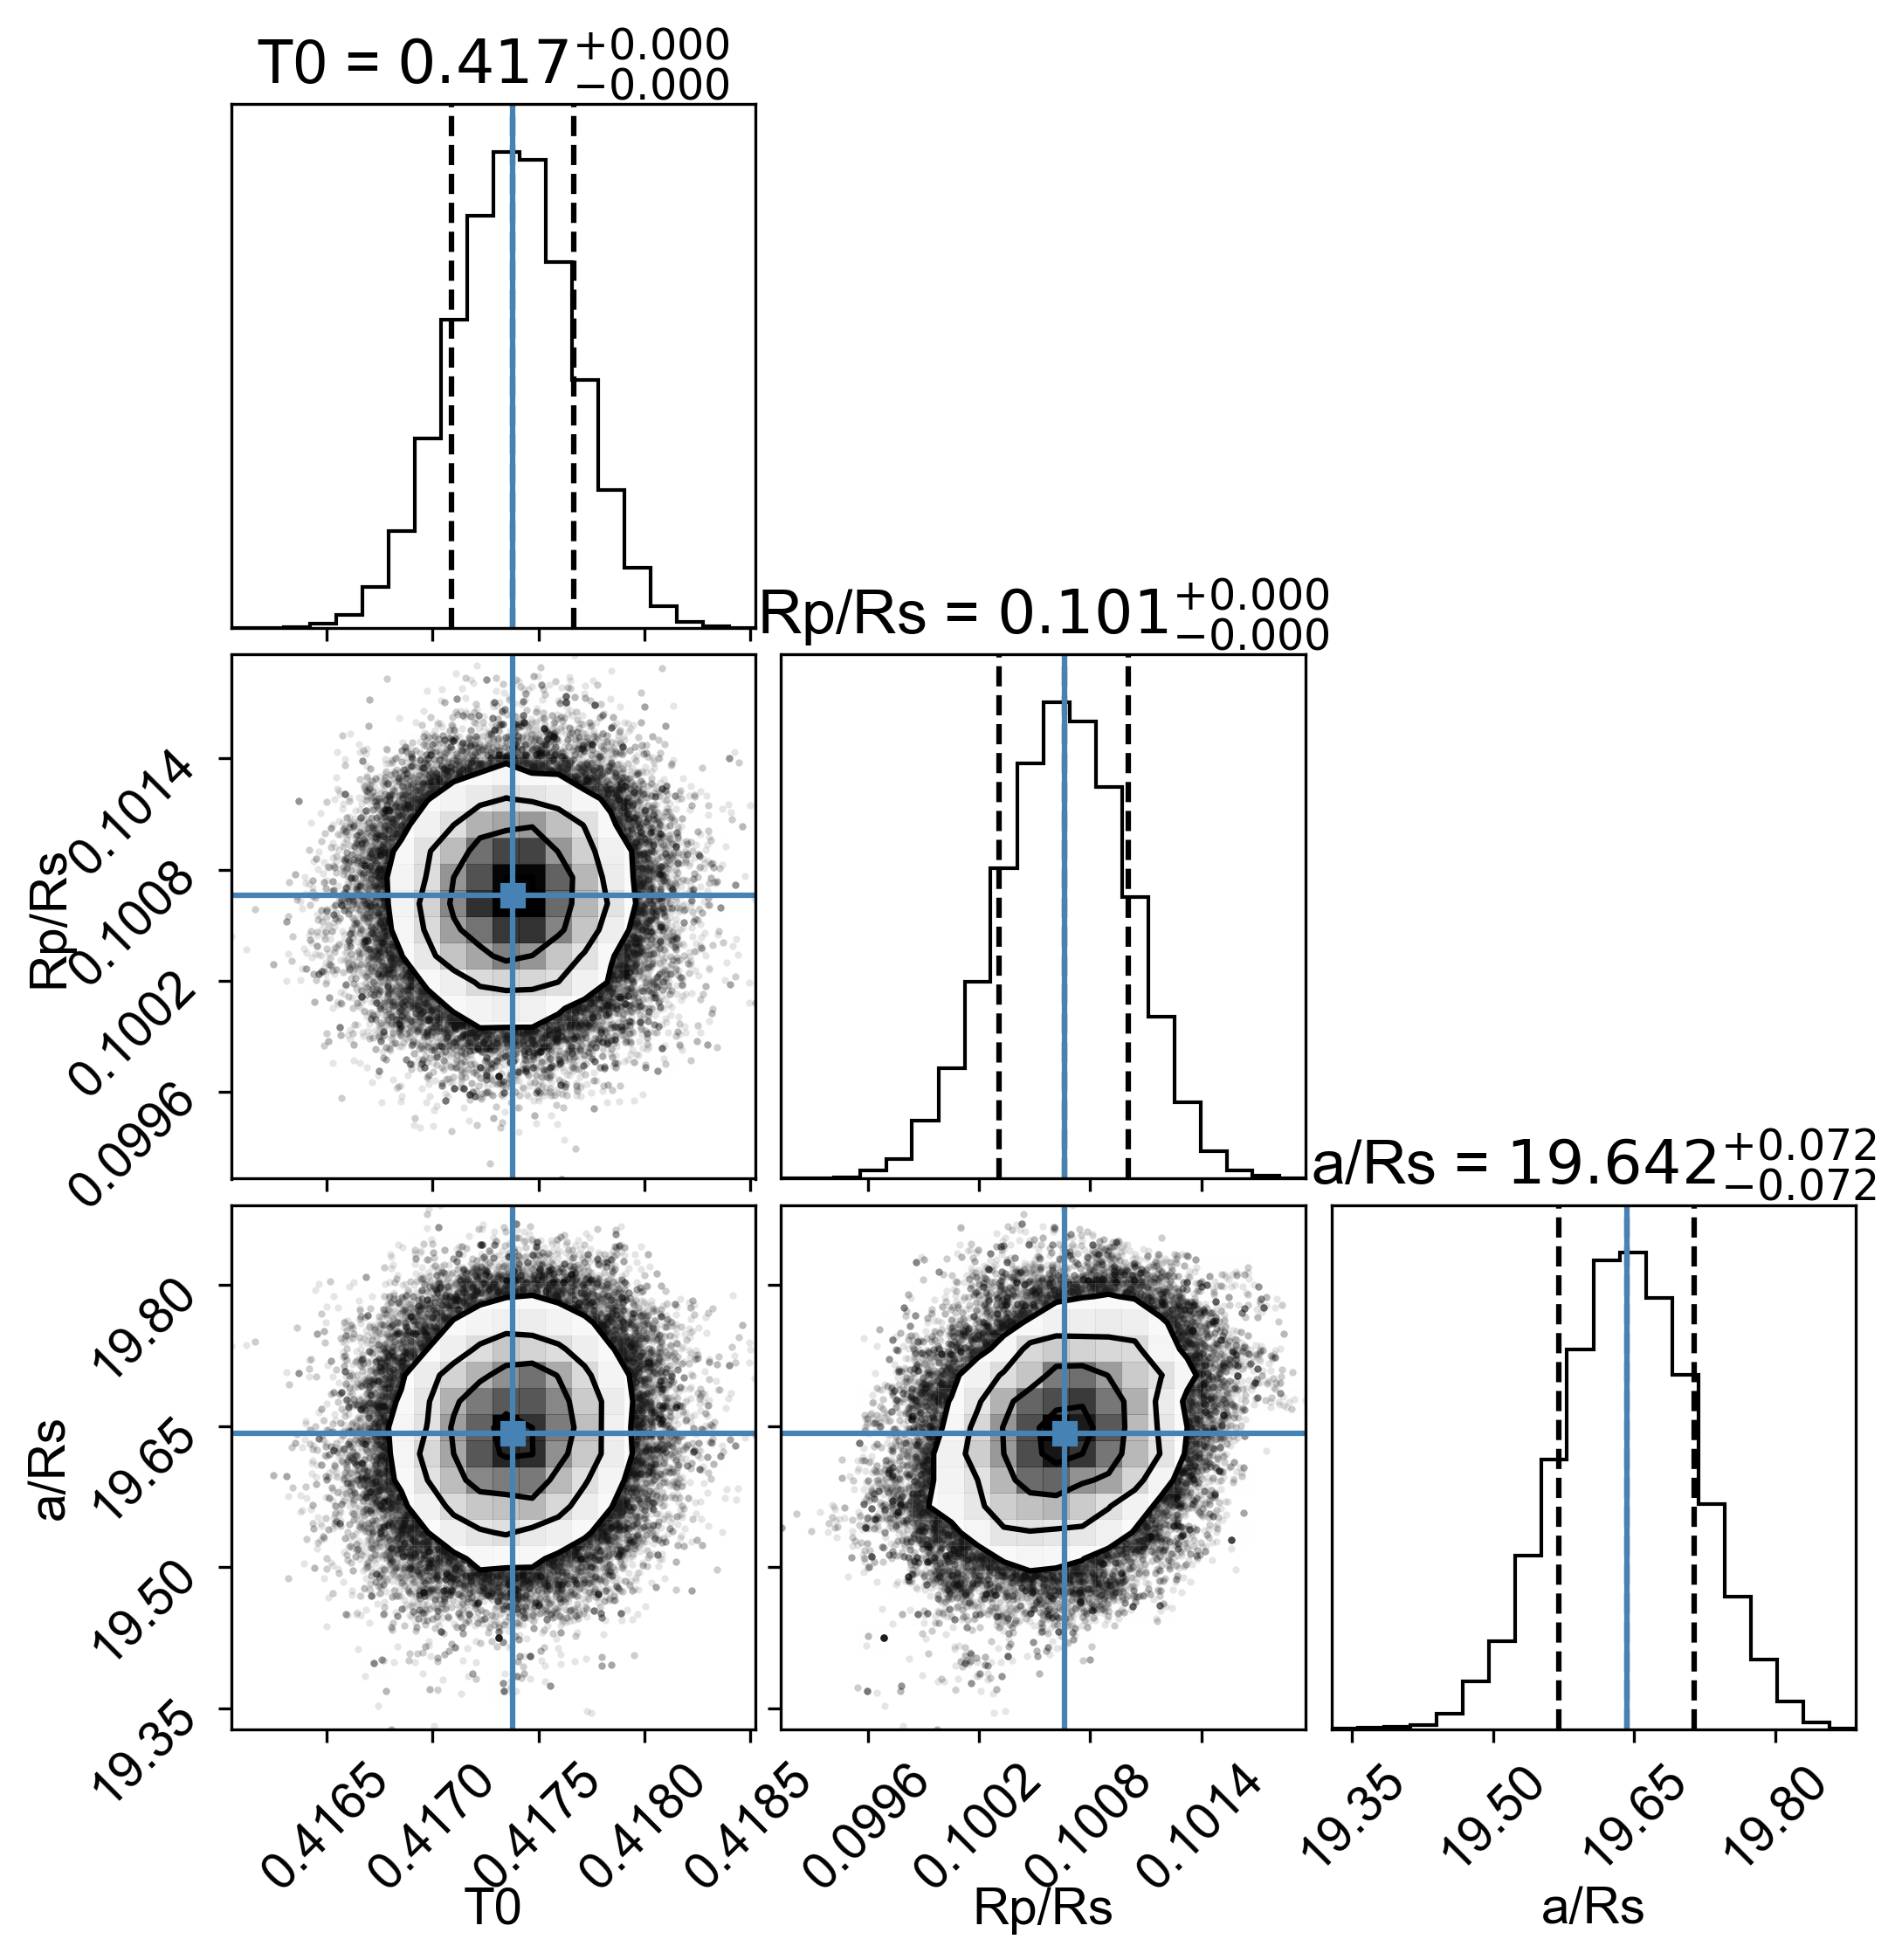

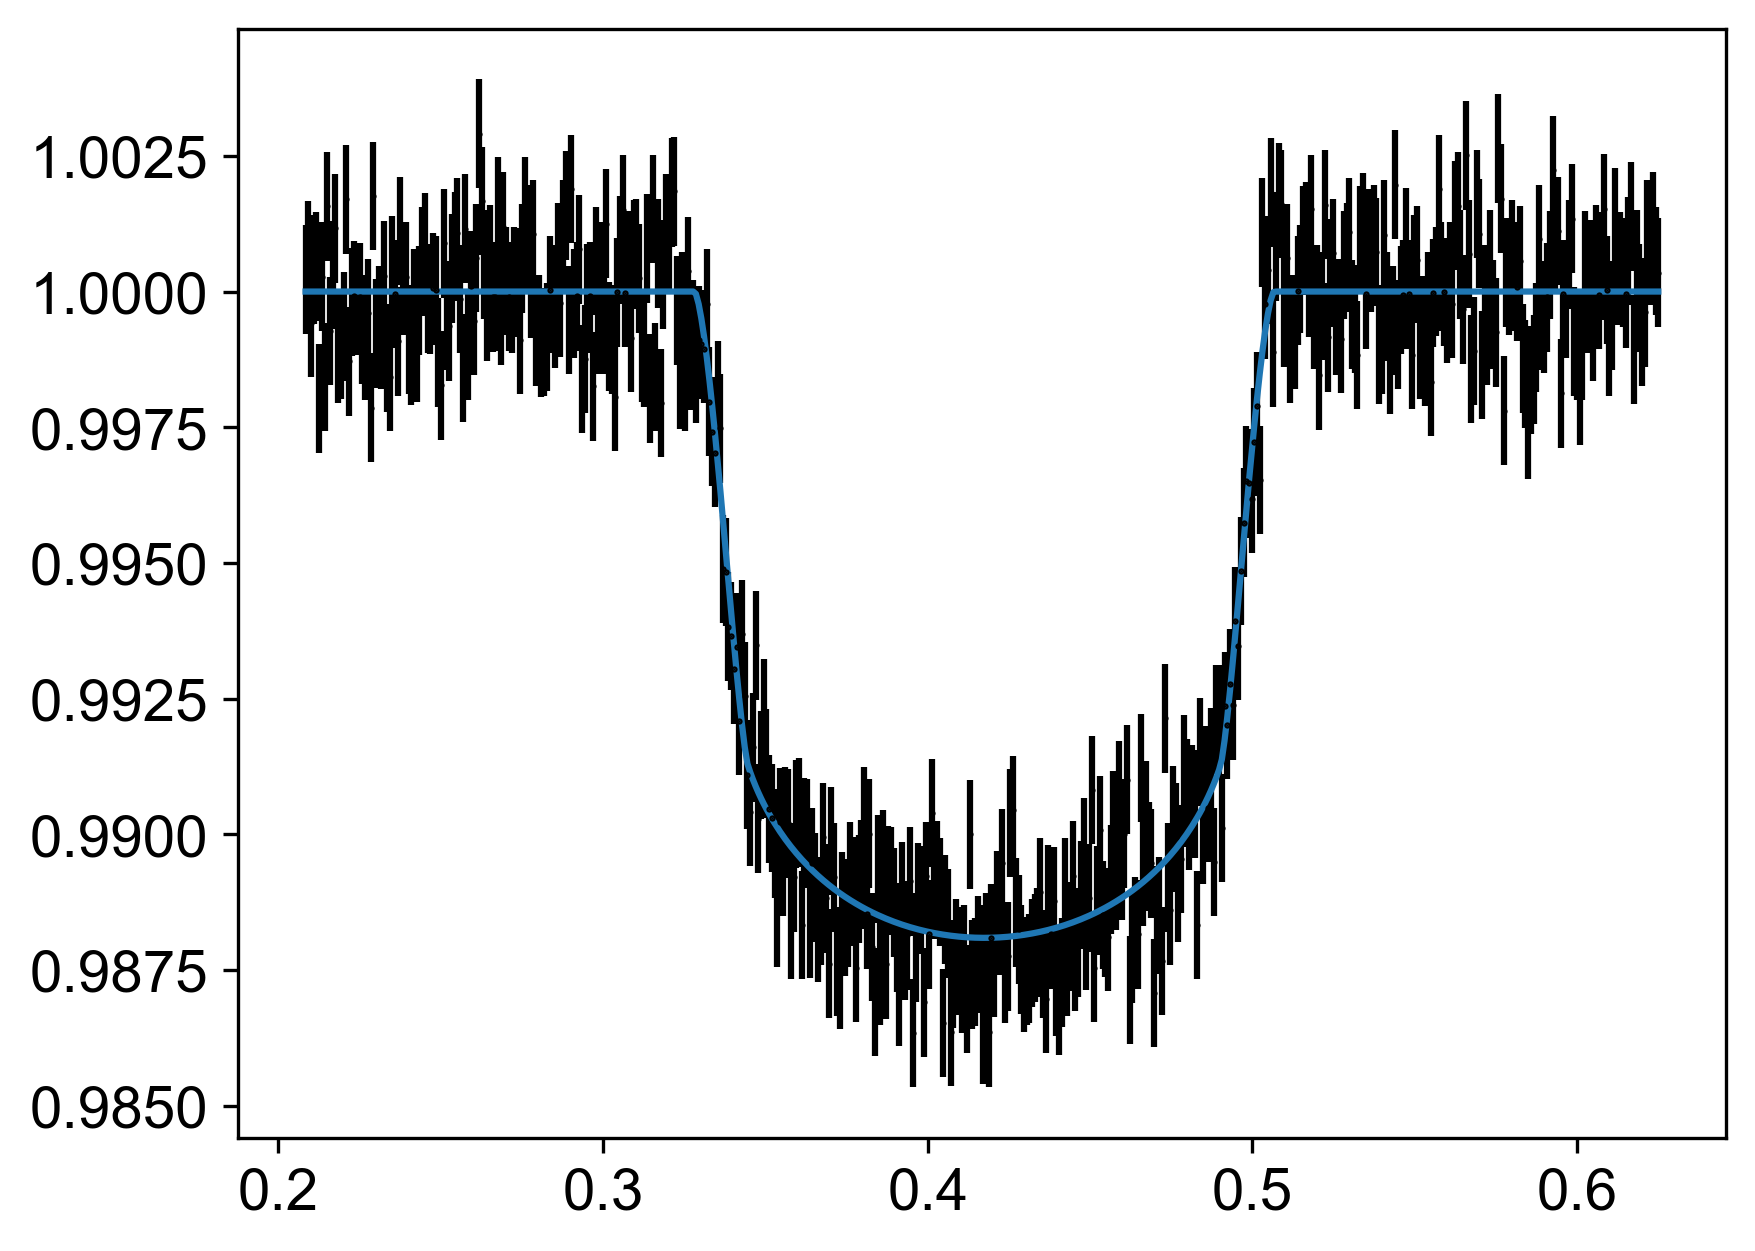

In [210]:
# Create a corner plot
fig = corner.corner(chain, labels=titles, truths=np.median(
    chain, axis=0), quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='.3f', )

# Show the plot
plt.show()

plt.errorbar(t, flux, errs, fmt='.', c='k', markersize=1)
plt.plot(t, get_transit(np.mean(chain, axis=0), t))
plt.show()

In [212]:
print('chi-square: ', sum(((flux-get_transit(np.mean(chain, axis=0), t))**2.)/(errs**2.)))

chi-square:  483.2355759951667
